<a href="https://colab.research.google.com/github/rht6226/InnoHAR-NeuralNet/blob/master/1D_CNN_Based_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1D CNN Based Model

In this module we will be training a model which uses the 1 dimensional Convolutional Neural Network Architecture for Human Activity recognition on UCI HAR Mobile Dataset. 

In [ ]:
# Imports
import numpy as np
from keras.utils import to_categorical
import json
import matplotlib

## Loading the dataset

In [ ]:
# Get class from file
from drive.MyDrive.InnoHAR.DatasetLoader import UciMobileDataset

In [ ]:
uci = UciMobileDataset(filepath='/content/drive/MyDrive/InnoHAR/ProcessedDataset/')
uci.summary()

UCI Human Activity Recognition Dataset: 
Shape of training data = X:(7352, 128, 9), y: (7352, 6)
Shape of testing data = X:(2947, 128, 9), y: (2947, 6)


## Creating the Model

In [ ]:
# Imports
import keras
from keras.models import Sequential, Model
from keras.layers import MaxPooling1D, Conv1D, Flatten, Dense, Concatenate, GRU, Input, Dropout, concatenate
from keras.utils.vis_utils import plot_model

In [ ]:
# This function defines the CNN model layer by layer
def get_1DCNN_model(trainX, trainy):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

    # Model Definitions
    model = Sequential(name='1DCNN')
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
# Summarising the model Architecture

model_1D_CNN = get_1DCNN_model(uci.trainX, uci.trainy)
model_1D_CNN.summary()

Model: "1DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 126, 64)           1792      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 126, 64)           4160      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 122, 64)           20544     
_________________________________________________________________
dropout_2 (Dropout)          (None, 122, 64)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 61, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3904)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               390500

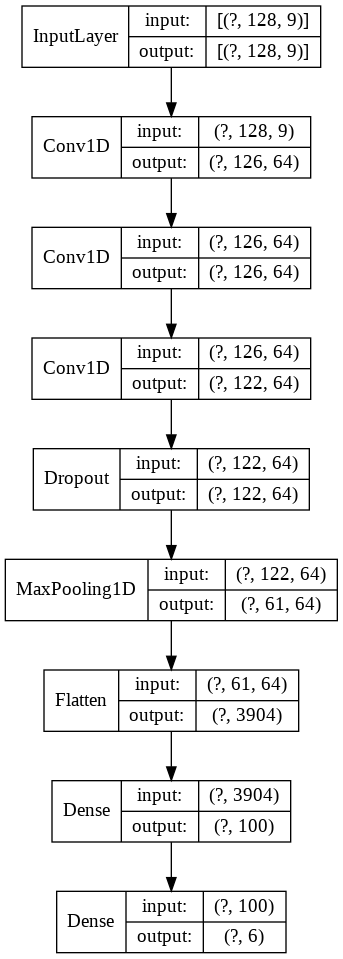

In [ ]:
# Plot model Layer by Layer
plot_model(model_1D_CNN, show_shapes=True, show_layer_names=False)

## Training the Models

Only one instance of a trained model cannot be used to determine the model performance. Hence we will be training Multiple instances of the same 1D CNN model and then we will find out the average accuracy.

In [ ]:
def train_models(X=uci.trainX, y=uci.trainy, num_instances=50, verbose=1, epochs=10, batch_size=32, valid_data = (uci.testX, uci.testy)):
    # Here we will store all the models
    modelList = []

    # Training multiple models at the same time for finding average accuracy
    for i in range(num_instances):
        print("\n<========== Now training model - {} ...... =======>".format(i))

        model = get_1DCNN_model(X, y)
        history = model.fit(X, y, epochs=epochs, verbose=1, batch_size=batch_size, validation_data=valid_data)

        print("<==================================================>\n")

        # Finding accuracy
        _, accuracy = model.evaluate(valid_data[0], valid_data[1], batch_size=32, verbose=0)

        modelList.append({
            "model": model,
            "history": history,
            "accuracy": accuracy
        })

    return modelList

In [ ]:
modelList = train_models()


<========== Now training model - 0 ...... =======>
Epoch 1/10
230/230 [==============================] - 1s 5ms/step - loss: 0.3862 - accuracy: 0.8443 - val_loss: 0.3576 - val_accuracy: 0.8809
Epoch 2/10
230/230 [==============================] - 1s 4ms/step - loss: 0.1455 - accuracy: 0.9419 - val_loss: 0.3828 - val_accuracy: 0.8951
Epoch 3/10
230/230 [==============================] - 1s 4ms/step - loss: 0.1197 - accuracy: 0.9516 - val_loss: 0.3193 - val_accuracy: 0.8935
Epoch 4/10
230/230 [==============================] - 1s 4ms/step - loss: 0.1160 - accuracy: 0.9509 - val_loss: 0.3518 - val_accuracy: 0.8877
Epoch 5/10
230/230 [==============================] - 1s 4ms/step - loss: 0.0969 - accuracy: 0.9567 - val_loss: 0.4169 - val_accuracy: 0.8979
Epoch 6/10
230/230 [==============================] - 1s 4ms/step - loss: 0.1123 - accuracy: 0.9544 - val_loss: 0.3563 - val_accuracy: 0.8965
Epoch 7/10
230/230 [==============================] - 1s 4ms/step - loss: 0.0900 - accuracy: 0.9

## Compare different instances

We will compare the different instances of trained model to find the one which gives the best performance. We will also find the average accuracy for the trained models.

In [ ]:
# Imports
import matplotlib.pyplot as plt
from statistics import mean 

In [ ]:
def plot_accuracies(modelList, modelName, figureSize=[8, 8]):
    accuracies = []
    for modelDict in modelList:
        accuracies.append(modelDict['accuracy'])
    mean_accuracy = mean(accuracies)
    matplotlib.rcParams['figure.figsize'] = figureSize
    plt.plot(accuracies)
    plt.axhline(y=mean_accuracy, color='r', linestyle='-')
    plt.title('Model accuracy for different instances of - {}'.format(modelName))
    plt.ylabel('accuracy')
    plt.xlabel('Instance #')
    plt.legend(['Instance Accuracy', 'Mean Accuracy'], loc='lower right')
    plt.show()
    
    print("\n\nThe average accuracy of this model was found out to be: {}".format(mean_accuracy))

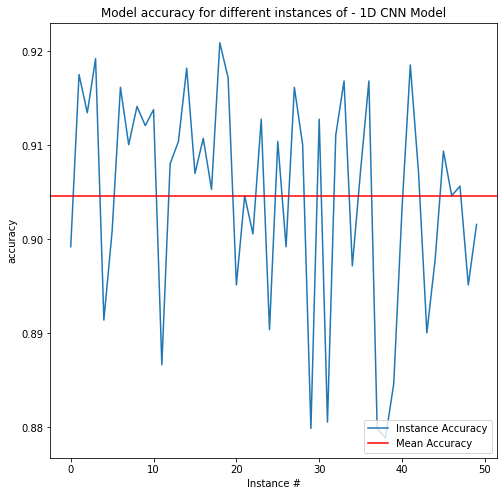



The average accuracy of this model was found out to be: 0.904628438949585


In [ ]:
plot_accuracies(modelList, modelName='1D CNN Model')

## Selecting Model closest to Mean

here we will be selecting a model instance whose performance is the closest to the mean accuracy. This will help us in comparision between various models.

In [ ]:
# Get functions from file
from drive.MyDrive.InnoHAR.helpers import get_average_model

In [ ]:
model, history = get_average_model(modelList)

In [ ]:
## Save Model
model.save('/content/drive/MyDrive/InnoHAR/SavedModels/1D_CNN.h5')

## Plotting Accuracy and Losses

In [ ]:
# Get functions from file
from drive.MyDrive.InnoHAR.helpers import plot_model_accuracy, plot_model_loss

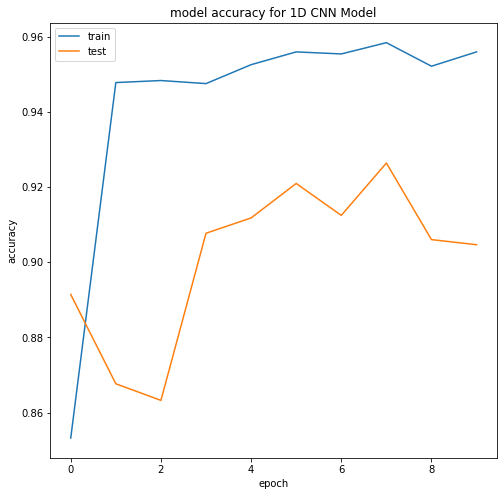

In [ ]:
plot_model_accuracy('1D CNN Model', history=history)

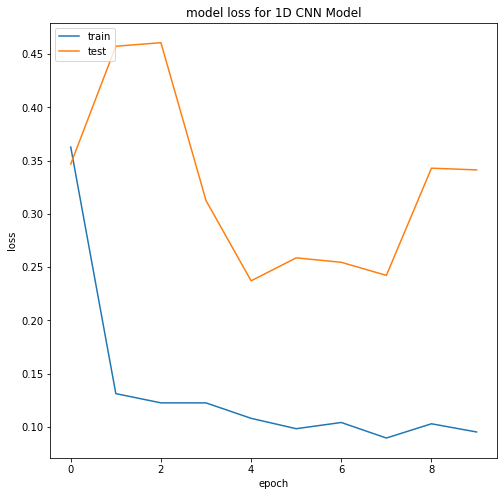

In [ ]:
plot_model_loss('1D CNN Model', history=history)

## Plotting Confusion Matrix

In [ ]:
# Get functions from file
from drive.MyDrive.InnoHAR.helpers import plot_cm

Confusion matrix, without normalization


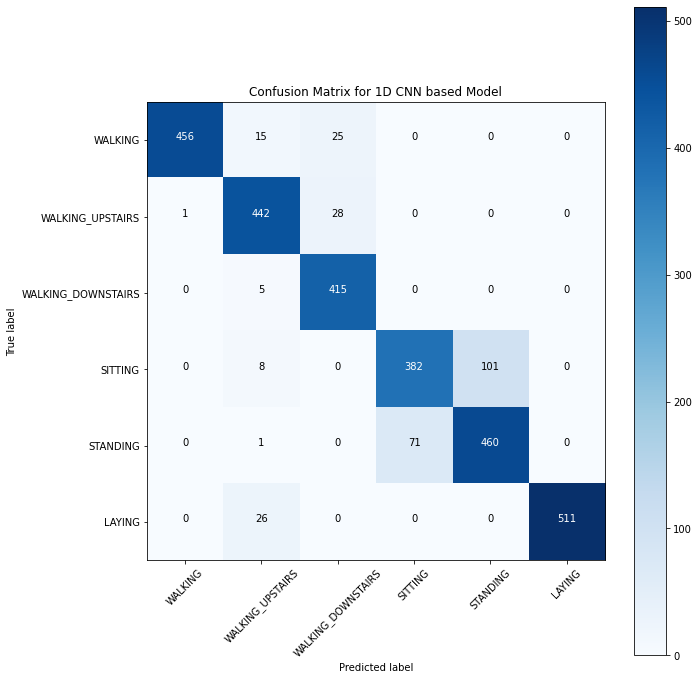

In [ ]:
plot_cm(model, test_data=(uci.testX, uci.testy), title='Confusion Matrix for 1D CNN based Model')

## Classification Report

In [ ]:
# Get functions from file
from drive.MyDrive.InnoHAR.helpers import print_classification_report

In [ ]:
print_classification_report(model, test_data=(uci.testX, uci.testy), title='1D CNN Model')

Classification Report for '1D CNN Model': 

                    precision    recall  f1-score   support

           WALKING    0.99781   0.91935   0.95698       496
  WALKING_UPSTAIRS    0.88934   0.93843   0.91322       471
WALKING_DOWNSTAIRS    0.88675   0.98810   0.93468       420
           SITTING    0.84327   0.77800   0.80932       491
          STANDING    0.81996   0.86466   0.84172       532
            LAYING    1.00000   0.95158   0.97519       537

          accuracy                        0.90465      2947
         macro avg    0.90619   0.90669   0.90519      2947
      weighted avg    0.90719   0.90465   0.90472      2947

